In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import os

In [2]:
data_df = pd.read_pickle('datasets/all_players_rel_all_actions_group_team_six_action_state.pkl')

data_df.head()

,season,gameId,playId,playIndex,timeIndex,state,next_state,reward,action,next_action
0,2018,2018090600,677,0,48,"[11.4, 42.67, 0.2, 3.07, 102.1, 312.17, 12.42,...","[11.39, 42.66, 0.21, 2.84, 105.48, 199.45, 11....",0.01,"[0.01, 0.01, -0.01, 0.23, -3.38, 112.72]","[-0.02, 0.03, -0.26, 0.31, -8.38, 31.09]"
1,2018,2018090600,677,0,49,"[11.39, 42.66, 0.21, 2.84, 105.48, 199.45, 11....","[11.41, 42.63, 0.47, 2.53, 113.86, 168.36, 11....",0.04,"[-0.02, 0.03, -0.26, 0.31, -8.38, 31.09]","[-0.04, 0.07, -0.36, 0.0, 3.17, 10.04]"
2,2018,2018090600,677,0,50,"[11.41, 42.63, 0.47, 2.53, 113.86, 168.36, 11....","[11.45, 42.56, 0.83, 2.53, 110.69, 158.32, 11....",0.08,"[-0.04, 0.07, -0.36, 0.0, 3.17, 10.04]","[-0.08, 0.11, -0.49, -0.5, -6.61, 10.26]"
3,2018,2018090600,677,0,51,"[11.45, 42.56, 0.83, 2.53, 110.69, 158.32, 11....","[11.53, 42.45, 1.32, 3.03, 117.3, 148.06, 11.1...",0.14,"[-0.08, 0.11, -0.49, -0.5, -6.61, 10.26]","[-0.09, 0.13, -0.38, -0.1, 2.88, 3.22]"
4,2018,2018090600,677,0,52,"[11.53, 42.45, 1.32, 3.03, 117.3, 148.06, 11.1...","[11.62, 42.32, 1.7, 3.13, 114.42, 144.84, 11.5...",0.16,"[-0.09, 0.13, -0.38, -0.1, 2.88, 3.22]","[-0.16, 0.16, -0.53, -0.24, -17.77, 7.48]"


In [3]:
'''
Function that splits the data into a training, validation, and test set
'''
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data_df, 0.7, 2430)

print(test_data.columns)

print(f"Length of training data: {len(train_data)}")

Index(['season', 'gameId', 'playId', 'playIndex', 'timeIndex', 'state',
       'next_state', 'reward', 'action', 'next_action'],
      dtype='object')
Length of training data: 154821


In [4]:
train_data.head()

,season,gameId,playId,playIndex,timeIndex,state,next_state,reward,action,next_action
71971,2018,2018122400,241,1393,217,"[50.39, 50.93, 9.23, 1.11, 264.59, 271.15, 50....","[49.46, 50.96, 9.23, 1.04, 265.35, 271.57, 49....",0.93,"[0.93, -0.03, 0.0, 0.07, -0.76, -0.42]","[0.93, -0.03, -0.02, 0.01, -2.67, -0.44]"
120674,2019,2019111707,754,2340,92,"[41.87, 35.12, 5.94, 5.62, 66.76, 40.92, 42.0,...","[42.24, 35.6, 6.1, 5.41, 54.33, 34.81, 42.4, 3...",0.60,"[-0.37, -0.48, -0.16, 0.21, 12.43, 6.11]","[-0.32, -0.52, -0.1, 0.46, 13.39, 5.69]"
42647,2018,2018111109,36,832,89,"[28.05, 28.02, 6.07, 2.64, 78.14, 136.12, 28.2...","[28.43, 27.6, 5.62, 3.32, 66.46, 137.72, 28.69...",0.57,"[-0.38, 0.42, 0.45, -0.68, 11.68, -1.6]","[-0.29, 0.39, 0.79, -1.29, 9.87, -4.58]"
150029,2019,2019122908,3355,2919,126,"[31.09, 12.59, 7.39, 0.52, 130.78, 170.44, 31....","[31.22, 11.85, 7.49, 0.29, 131.54, 170.41, 31....",0.75,"[-0.13, 0.74, -0.1, 0.23, -0.76, 0.03]","[-0.12, 0.75, -0.13, -0.1, 0.0, -0.41]"
154546,2020,2020091310,3298,3003,109,"[38.7, 47.07, 3.09, 4.23, 4.0, 46.57, 38.86, 4...","[38.9, 47.27, 2.47, 4.73, 10.97, 51.91, 39.05,...",0.28,"[-0.2, -0.2, 0.62, -0.5, -6.97, -5.34]","[-0.2, -0.1, 0.66, -0.73, -6.56, -11.86]"


In [5]:
def test_loop(test_df, model, loss_fn, device):
    size = len(test_df)
    test_loss = 0
    
    with torch.no_grad():
        for row_index in range(0,len(test_df)):

            play = test_df.iloc[row_index, :]

            true_state = torch.tensor(play['state'], dtype=torch.float32).to(device=device)
            true_action = torch.tensor(play['action'], dtype=torch.float32).to(device=device)
            
            # useful for if testing in batches
            #true_state = torch.tensor(np.stack(play['state'].values), dtype=torch.float32).to(device=device)
            #true_action = torch.tensor(np.stack(play['action'].values), dtype=torch.float32).to(device=device)

            numpy_state_input = play['state'].reshape(1, 1, -1, action_size)
                           
            true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
            
            
            # do this because forget to replace nans in next state in dataset construction
            #next_state = torch.nan_to_num(next_state, nan=0)

            # Why does a state have nan values?
            #state = torch.nan_to_num(state, nan=0)

            model.eval()  # put model to eval mode

            #compute prediction and loss
            predicted_action = model(true_state_mod)
            
            true_action = torch.unsqueeze(true_action, 0)
            
            loss = loss_fn(predicted_action, true_action)
            
            test_loss += loss
        
        test_loss /= size

    
    return test_loss

In [5]:
'''
Given indices, train model on batch
'''
def train_loop(df, indices, model, loss_fn, optimizer, device):
    size = len(indices)
    play = df.iloc[indices, :]
    
    numpy_state = np.stack(play['state'].values)
    batch_size = numpy_state.shape[0]
    numpy_state_input = numpy_state.reshape(batch_size, 1, -1, action_size)
                           

    true_state = torch.tensor(numpy_state, dtype=torch.float32).to(device=device)
    true_action = torch.tensor(np.stack(play['action'].values), dtype=torch.float32).to(device=device)
    
    # shape true state into matrix to pass into CNN
    #true_state_mod = true_state.reshape(batch_size, -1, len(true_action))
    true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
    
    # do this because forget to replace nans in next state in dataset construction
    #next_state = torch.nan_to_num(next_state, nan=0)

    # Why does a state have nan values?
    #state = torch.nan_to_num(state, nan=0)

    model.train()  # put model to training mode

    #compute prediction and loss
    predicted_action = model(true_state_mod)
    
    loss = loss_fn(predicted_action, true_action)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [7]:
'''
Define models
'''

'''
Input: Takes in a (state,action) pair
Output: Outputs a Q-score

class CNN(nn.Module):
    def __init__(self, num_people, state_size, action_size):
        super(CNN, self).__init__()
        
        self.num_people = num_people
        self.state_size = state_size
        self.action_size = action_size
        
        self.layer2_size = (state_size+action_size)*2
        
        #self.batch_initial = nn.BatchNorm1d(state_size+action_size)
        self.batch1 = nn.BatchNorm1d(self.layer2_size)
        self.linear1 = nn.Linear(state_size+action_size, self.layer2_size)
        self.linear2 = nn.Linear(self.layer2_size, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inp):
        
        #inp = self.batch_initial(inp)
        
        layer1_output = self.relu(self.batch1(self.linear1(inp)))
        output = self.linear2(layer1_output)
        return output
'''

'''
Define hyperparamters
'''
BATCH_SIZE = 128
iterations = 25000
state_size = len(data_df.loc[0,'state'])
action_size = 6
gamma = 0.99
#max_action = torch.tensor(max_action, dtype=torch.float32).to(device=device)

print(f"State size: {state_size}")
print(f"Action size: {action_size}")
    
'''
cnn_model = nn.Sequential(
    nn.Conv2d(1, 8, (12,1), stride=1,padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, (6, 1)),
    nn.LeakyReLU(),
    nn.Conv2d(4,1, (1,action_size)),
    nn.Flatten(),
    nn.Linear(7,action_size)
)
'''

cnn_model = nn.Sequential(
    nn.Conv2d(1, 12, (12,1), stride=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(12, 24, (6, 1)),
    nn.LeakyReLU(),
    nn.Conv2d(24, 48, (1,1)),
    nn.Flatten(),
    nn.Linear(48*7*6,action_size)
)

cnn_model.to(device=device)
    

State size: 138
Action size: 6


Sequential(
  (0): Conv2d(1, 12, kernel_size=(12, 1), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(12, 24, kernel_size=(6, 1), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2016, out_features=6, bias=True)
)

In [8]:
# create models
#cnn_model = CNN(state_size, action_size, max_action).to(device=device)

# define loss function
mse_loss_fn = nn.MSELoss()
# define optimizers
cnn_optimizer = optim.Adam(cnn_model.parameters())

In [10]:
import random

epochs = 7
break_var = False
training_loss_list = []
val_loss_list = []

num_batches = int(len(train_data)/BATCH_SIZE)+1

print(f"Num batches: {num_batches}")

indexes = list(range(0,len(train_data)))

np.random.seed(2430)


for k in range(epochs):
    
    random.shuffle(indexes)
    
    for i in range(num_batches):

        start_index = i*BATCH_SIZE
        end_index = min(len(train_data), (i+1)*BATCH_SIZE)
        
        #indices = list(range(start_index, end_index))
        indices = indexes[start_index:end_index]

        train_loss = train_loop(train_data, indices, cnn_model, mse_loss_fn, cnn_optimizer, device)
        
        training_loss_list.append(train_loss)

        if (i % int(num_batches/3) == 0): #and (i != 0):
            val_loss = test_loop(val_data, cnn_model, F.mse_loss, device)
            val_loss_list.append(val_loss)
            print(f"At epoch {k}, iter {i}: train loss = {train_loss}")
            print(f"At epoch {k}, iter {i}: val loss = {val_loss}")

Num batches: 1210
At epoch 0, iter 0: train loss = 662.260986328125
At epoch 0, iter 0: val loss = 584.028076171875
At epoch 0, iter 403: train loss = 262.66314697265625
At epoch 0, iter 403: val loss = 389.967529296875
At epoch 0, iter 806: train loss = 457.96490478515625
At epoch 0, iter 806: val loss = 387.2698669433594
At epoch 0, iter 1209: train loss = 342.30694580078125
At epoch 0, iter 1209: val loss = 387.0239562988281
At epoch 1, iter 0: train loss = 434.3843994140625
At epoch 1, iter 0: val loss = 386.1576843261719
At epoch 1, iter 403: train loss = 286.12359619140625
At epoch 1, iter 403: val loss = 388.03704833984375
At epoch 1, iter 806: train loss = 421.2496032714844
At epoch 1, iter 806: val loss = 386.3711242675781
At epoch 1, iter 1209: train loss = 792.4215698242188
At epoch 1, iter 1209: val loss = 385.07843017578125
At epoch 2, iter 0: train loss = 902.8453369140625
At epoch 2, iter 0: val loss = 385.06658935546875
At epoch 2, iter 403: train loss = 429.87689208984

In [11]:

torch.save(cnn_model.state_dict(), 'saved_models/cnn_model_3.pt')

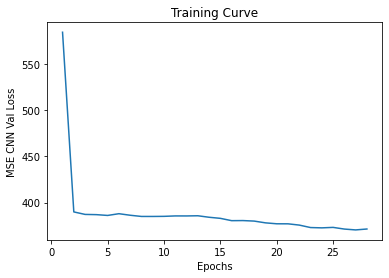

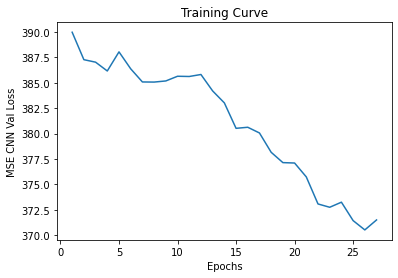

In [13]:
def plot_history(history_list, metric, filename):
    
    fig, ax = plt.subplots()

    # plotting
    ax.plot(list(range(1,len(history_list)+1)), history_list)
    plt.title("Training Curve")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.show()

    #file_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), filename)
    fig.savefig(filename)
    
new_val_list = [x.detach().cpu() for x in val_loss_list]
    
plot_history(new_val_list, metric='MSE CNN Val Loss', filename='training_plots/cnn_model_2.png')
plot_history(new_val_list[1:], metric='MSE CNN Val Loss', filename='training_plots/cnn_model_2_no_first_entry.png')

In [8]:
cnn_model.load_state_dict(torch.load("saved_models/cnn_model_2.pt"))
cnn_model.eval()

Sequential(
  (0): Conv2d(1, 12, kernel_size=(12, 1), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(12, 24, kernel_size=(6, 1), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2016, out_features=6, bias=True)
)

In [9]:
def compare_actions(df, row_index, cnn_model, verbose=False, save=False):
    
    play = df.iloc[row_index, :]

    numpy_state_input = play['state'].reshape(1, 1, -1, action_size)
    true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
    
    cnn_model.eval()
    next_action = cnn_model(true_state_mod).detach().cpu()
    
    print(f"next action: {next_action}")
    
    true_action = play['action']
    print(f"true action: {true_action}")

    fig, ax = plt.subplots()

    ax.scatter(true_action[0], true_action[1], c='red', s=50)
    ax.scatter(next_action[0,0], next_action[0,1], c='blue', s=50)
    ax.annotate('TRUE', (true_action[0], true_action[1]) )
    #ax.annotate('PREDICTED', (actor_next_action[0,0].detach().cpu(), actor_next_action[0,1].detach().cpu()))
    plt.title("True vs Predicted Action")
    plt.xlabel("X pos")
    plt.ylabel("Y pos")
    plt.xlim(-3,3)
    plt.ylim(-3,3)

    if save:
        plt.savefig("general_images/cnn2_prediction.png")
    plt.show()

next action: tensor([[ 0.3335,  0.2886,  0.2315,  0.0350,  2.4803, -4.8323]])
true action: [ 0.15  0.42  0.28  0.03 -1.09 -3.03]


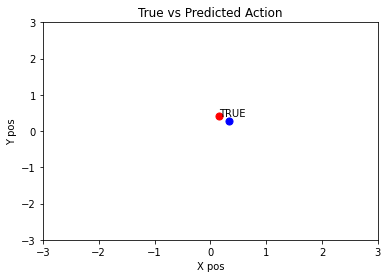

next action: tensor([[-0.3686,  0.3426,  0.0435, -0.0698, -4.7020, -2.5546]])
true action: [-0.76  0.55  0.07 -0.71  5.92  2.66]


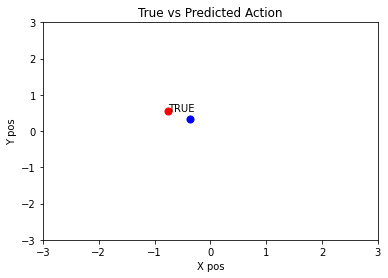

next action: tensor([[-0.1747,  0.3316,  0.0858,  0.0747, -4.3499,  1.0469]])
true action: [-0.16  0.51 -0.37  0.57  1.06 -1.09]


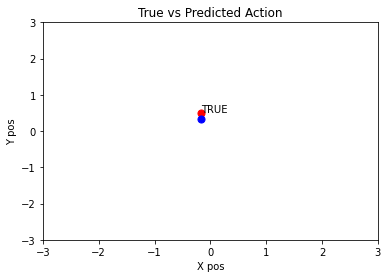

next action: tensor([[ -0.2549,  -0.1239,   0.2160,   0.0966,  -9.4420, -11.5020]])
true action: [-0.51 -0.32  0.25  0.62  0.   -3.79]


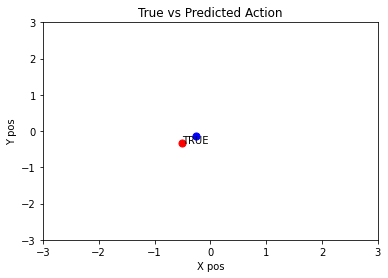

next action: tensor([[ 0.6085, -0.5398,  0.2262, -0.0404,  7.7011,  1.8925]])
true action: [ 0.08 -0.54  0.52 -0.54  9.95  4.6 ]


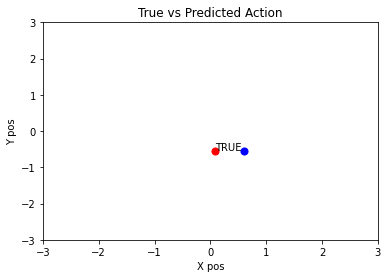

next action: tensor([[ 0.4647,  0.0605,  0.1610,  0.0025,  0.2223, -1.1571]])
true action: [ 0.52  0.11 -0.22  0.81  5.94 -0.65]


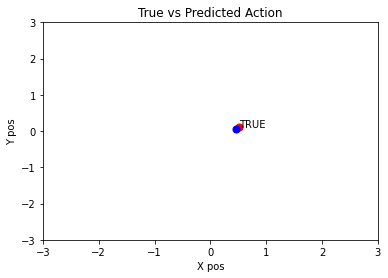

next action: tensor([[-0.4415,  0.2598, -0.2142,  0.2563, -3.6213,  4.0374]])
true action: [-0.34  0.04 -0.28  0.07  0.    6.2 ]


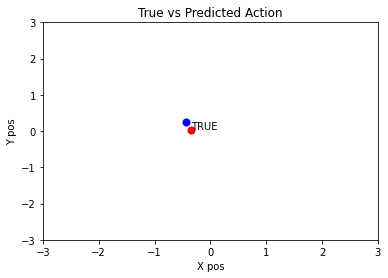

next action: tensor([[ 0.4346,  0.1806,  0.2355,  0.1640, -2.3605,  5.0989]])
true action: [ 0.49 -0.31  0.79 -0.81  4.51 -3.91]


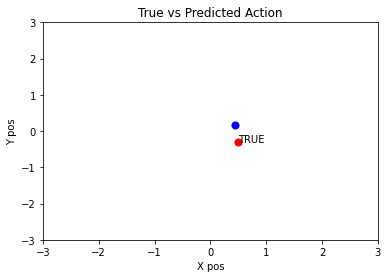

next action: tensor([[ 2.4092e-02,  6.0180e-02, -2.1738e-03,  3.1527e-02,  4.0663e+00,
         -2.9671e+00]])
true action: [-0.32 -0.2   0.43 -0.22  7.54 -5.54]


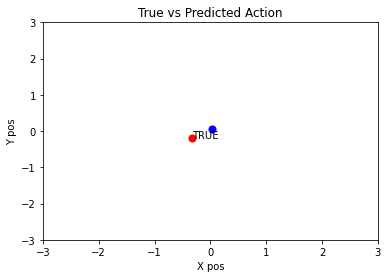

next action: tensor([[ 0.6032,  0.1637, -0.1699, -0.0797,  0.0524, -2.9263]])
true action: [ 0.38 -0.03 -0.42  0.07  3.18 -0.38]


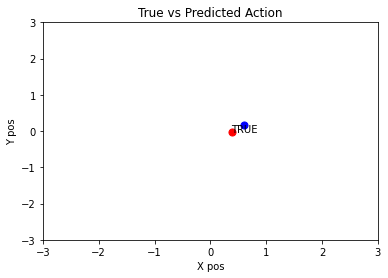

In [18]:
for row_index in range(10,20):
    compare_actions(test_data, row_index, cnn_model, verbose=False)

In [11]:
test_data.head()

,playIndex,timeIndex,state,next_state,reward,action,next_action
3853,70,109,"[84.52, 2.95, 2.88, 4.89, 279.1, 187.79, 84.92...","[84.49, 2.68, 2.61, 4.37, 248.06, 181.32, 84.8...",0.27,"[0.03, 0.27, 0.27, 0.52, 31.04, 6.47]","[0.01, 0.23, 0.25, 0.58, 22.64, 5.95]"
163361,3178,107,"[75.65, 45.3, 8.29, 1.91, 313.83, 325.48, 75.5...","[75.17, 45.98, 8.25, 1.91, 313.83, 323.9, 75.0...",0.83,"[0.48, -0.68, 0.04, 0.0, 0.0, 1.58]","[0.48, -0.66, 0.12, -0.02, 0.65, 1.05]"
121000,2345,103,"[29.16, 28.58, 0.21, 0.04, 111.48, 154.88, 29....","[29.17, 28.56, 0.17, 0.61, 119.02, 130.2, 29.6...",0.02,"[-0.01, 0.02, 0.04, -0.57, -7.54, 24.68]","[-0.02, 0.01, 0.01, -0.21, 73.63, 20.74]"
115218,2238,78,"[27.07, 24.58, 7.48, 4.16, 2.64, 20.99, 26.96,...","[27.32, 25.28, 7.46, 3.8, 359.81, 17.79, 27.2,...",0.75,"[-0.25, -0.7, 0.02, 0.36, -357.17, 3.2]","[-0.22, -0.72, 0.04, 0.66, 358.85, 2.15]"
142632,2787,84,"[75.87, 26.03, 1.05, 2.04, 220.19, 181.78, 75....","[75.86, 25.86, 1.59, 2.6, 239.39, 181.71, 75.6...",0.17,"[0.01, 0.17, -0.54, -0.56, -19.2, 0.07]","[0.0, 0.2, -0.45, -0.28, 7.57, -0.34]"


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [22]:
tracking2018 = pd.read_csv("csv/tracking2018.csv")
tracking2019 = pd.read_csv("csv/tracking2019.csv")
tracking2020 = pd.read_csv("csv/tracking2020.csv")

In [32]:
tracking2020.query('playId == 3178').head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
10255309,2020-09-27T22:47:51.600,37.13,20.99,0.04,0.04,0.02,327.58,292.53,None,34707.0,Ryan Succop,3.0,K,away,1,2020092711,3178,left
10255310,2020-09-27T22:47:51.700,37.11,20.99,0.04,0.04,0.01,326.45,291.29,None,34707.0,Ryan Succop,3.0,K,away,2,2020092711,3178,left
10255311,2020-09-27T22:47:51.800,37.10,21.00,0.03,0.04,0.02,327.04,292.06,None,34707.0,Ryan Succop,3.0,K,away,3,2020092711,3178,left
10255312,2020-09-27T22:47:51.900,37.09,21.00,0.03,0.04,0.01,327.04,290.35,None,34707.0,Ryan Succop,3.0,K,away,4,2020092711,3178,left
10255313,2020-09-27T22:47:52.000,37.08,21.00,0.03,0.03,0.01,327.04,289.40,None,34707.0,Ryan Succop,3.0,K,away,5,2020092711,3178,left


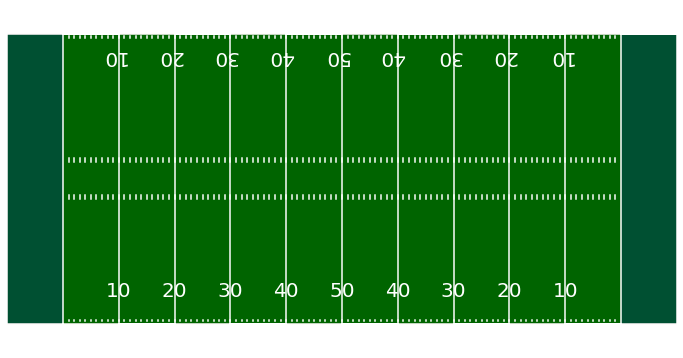

In [16]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

first_entry = tracking2018.query('time == @time and gameId == @gameId')
fig, ax = create_football_field()
first_entry.query("team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='red', s=30, legend='Away')
first_entry.query("team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
first_entry.query("displayName == 'football'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=50, legend='Football')
plt.title('Plot Teams')
plt.legend()
plt.show()